In [4]:
import math
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

from divide_chapters import _PREPROCESSED_PATH
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from scipy.interpolate import interp1d

In [346]:
# params
chpt_part_num = 1  # In how many parts should one chapter be split
book_id = 2 # 0=all, 1=red rising 1, 2=red rising 2

In [347]:
text_df = pd.DataFrame(columns=["book", "chapter", "text"])

for book in os.scandir(_PREPROCESSED_PATH):
    chapters = os.listdir(book.path)
    chapters.sort(key=lambda x: int(x.split('_')[0]))
    for chapter in chapters:
        with open(os.path.join(book.path, chapter), 'r') as chpt_file:
            chpt_text = chpt_file.read()
            text_df.loc[len(text_df.index)] = pd.Series({
                "book": book.name,
                "chapter": chapter,
                "text": chpt_text
            })

text_df.chapter = text_df.chapter.str.replace('.txt', '')

# text_df = text_df.set_index(["book", "chapter"])

/var/folders/nl/063yds355gn2cv90cc5fk6cw0000gn/T/ipykernel_91349/3352562927.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  text_df.chapter = text_df.chapter.str.replace('.txt', '')


In [348]:
# split text into sentences
text_df.text = text_df.text.apply(sent_tokenize)

# split array of sentences into chpt_part_num parts
if chpt_part_num > 1:
    text_df.text = text_df.text.map(lambda x: [x[(len(x) // chpt_part_num)*i:(len(x) // chpt_part_num)*(i+1)] for i in range(chpt_part_num)])
    text_parts = zip(*text_df.pop("text"))
    t_parts_df = pd.DataFrame(text_parts, index=["part_%i" % i for i in range(chpt_part_num)]).T
    t_parts_df["chapter"] = text_df.chapter
    t_parts_df = t_parts_df.set_index("chapter").stack().rename_axis(["chapter", "part"]).reset_index(name="text")
    text_df = pd.merge(t_parts_df, text_df, left_on="chapter", right_on="chapter")
    text_df = text_df.set_index(["chapter", "part"])
else:
    text_df = text_df.set_index(["chapter"])

In [349]:
text_df.text = text_df.text.apply(''.join)

In [350]:
regex = r'[^\w\s]'
text_df.text = text_df.text.str.replace(regex, '', regex=True)

In [351]:
mask = text_df.book=="red_rising_1"
if book_id == 1:
    data = text_df[mask]
elif book_id == 2:
    data = text_df[~mask]
else:
    data = text_df

In [352]:
stop_words = ENGLISH_STOP_WORDS.union(["know", "like", "dont", "want", "say", "au", "did", "think", "says", "just", "youre", "man", "eyes", "im"])
vect = TfidfVectorizer(stop_words=stop_words, tokenizer=word_tokenize)
X_token = vect.fit_transform(data.text)

In [332]:
tc_nmpi_dict = {}

In [356]:
epsilon = 0.0001
text_tokens = text_df.text.apply(str.lower).apply(word_tokenize).apply(set)

for n_components in range(6, 7):
    print("progress: %i/29" % n_components)
    model = NMF(n_components=n_components, max_iter=2000, tol=1e-20)
    nmf_features_token = model.fit_transform(X_token)
    comp_df_token = pd.DataFrame(model.components_, columns=vect.get_feature_names_out())
    topic_progression = pd.DataFrame(nmf_features_token)

    # testing
    topic_labels = comp_df_token.idxmax(axis=1)

    tc_nmpi = 0
    for idx, topic_x in topic_labels.items():
        if idx > 0:
            for idy, topic_y in topic_labels.items():
                if idx > idy:
                    pxy = text_tokens.apply(lambda doc: topic_x in doc and topic_y in doc).sum() / text_tokens.shape[0]
                    px = text_tokens.apply(lambda doc: topic_x in doc).sum() / text_tokens.shape[0]
                    py = text_tokens.apply(lambda doc: topic_y in doc).sum() / text_tokens.shape[0]
                    tc_nmpi += np.log((pxy + epsilon) / (px * py)) / -np.log(pxy + epsilon)
    tc_nmpi= tc_nmpi / math.comb(n_components, 2)
    if n_components in tc_nmpi_dict and tc_nmpi <= tc_nmpi_dict[n_components]["score"]:
        continue
    tc_nmpi_dict[n_components] = {
        "score": tc_nmpi,
        "topic_progression": topic_progression,
        "comp_df_token": comp_df_token
    }

progress: 6/29


/Users/benedikt/miniforge3/envs/irtm/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


In [357]:
tc_nmpi_df = pd.DataFrame(tc_nmpi_dict).T
# tc_nmpi_df.to_csv(str(book_id) + "_nmpi_parts_" + str(chpt_part_num) + ".csv")

In [152]:
tc_nmpi_df_1 = pd.DataFrame({
    'no chapter splitting': pd.read_csv("1_nmpi.csv", index_col=0).score,
    '2 parts': pd.read_csv("1_nmpi_parts_2.csv", index_col=0).score,
    '3 parts': pd.read_csv("1_nmpi_parts_3.csv", index_col=0).score,
})

tc_nmpi_df_2 = pd.DataFrame({
    'no chapter splitting': pd.read_csv("2_nmpi.csv", index_col=0).score,
    '2 parts': pd.read_csv("2_nmpi_parts_2.csv", index_col=0).score,
    '3 parts': pd.read_csv("2_nmpi_parts_3.csv", index_col=0).score,
})

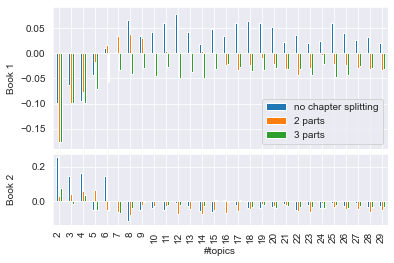

In [178]:
from matplotlib import gridspec

fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = plt.subplot(gs[0])
ax1.set_ylabel("Book 1")
# plt.ylabel("TC-NPMI", loc='bottom')

tc_nmpi_df_1.plot.bar(ax=ax1, label='Book1')

# shared axis X
ax2 = plt.subplot(gs[1], sharex = ax1)
ax2.set_xlabel("#topics")
ax2.set_ylabel("Book 2")
tc_nmpi_df_2.plot.bar(ax=ax2)
plt.setp(ax1.get_xticklabels(), visible=False)

# remove last tick label for the second subplot
yticks = ax2.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)

# remove vertical gap between subplots
ax2.get_legend().remove()
fig.align_ylabels()
plt.subplots_adjust(hspace=.05)

plt.savefig("comparison_nmpi.png", dpi=500, format="png", transparent=True)
plt.show()

In [281]:
tc_nmpi_df = pd.read_csv("1_nmpi.csv", index_col=0)

In [358]:
# best_model = tc_nmpi_df.loc[tc_nmpi_df.score.apply(float).argmax()]
best_model = tc_nmpi_df.loc[6]
comp_df_token = best_model["comp_df_token"]
topic_progression = best_model["topic_progression"]

In [359]:
for topic in range(comp_df_token.shape[0]):
    tmp = comp_df_token.iloc[topic]
    print(#"\\begin{table}[ht]\n",
          #"\\centering\n",
          "\\begin{tabular}{c|c}\n" +
          "\\multicolumn{2}{c}{Topic %i} \\\\\n" % (topic+1) +
          "word & NMF score \\\\\n" +
          "\hline", end='\n')

    for word, score in tmp.nlargest(10).items():
        print(word + " & " + str(round(score, 3)) + "\\\\")

    print("\end{tabular}",
          #"\end{table}\n"
          )

\begin{tabular}{c|c}
\multicolumn{2}{c}{Topic 1} \\
word & NMF score \\
\hline
sevro & 0.351\\
bridge & 0.162\\
wall & 0.143\\
ship & 0.141\\
men & 0.139\\
blues & 0.13\\
ragnar & 0.127\\
grays & 0.126\\
mud & 0.125\\
ships & 0.125\\
\end{tabular}
\begin{tabular}{c|c}
\multicolumn{2}{c}{Topic 2} \\
word & NMF score \\
\hline
pliny & 0.453\\
augustus & 0.19\\
leto & 0.144\\
table & 0.129\\
liege & 0.122\\
power & 0.113\\
lorn & 0.106\\
kavax & 0.105\\
mustang & 0.105\\
archgovernor & 0.082\\
\end{tabular}
\begin{tabular}{c|c}
\multicolumn{2}{c}{Topic 3} \\
word & NMF score \\
\hline
kavax & 0.52\\
daxo & 0.414\\
jelly & 0.238\\
orion & 0.147\\
fox & 0.125\\
percent & 0.125\\
beans & 0.111\\
haggle & 0.093\\
anticipation & 0.091\\
headim & 0.091\\
\end{tabular}
\begin{tabular}{c|c}
\multicolumn{2}{c}{Topic 4} \\
word & NMF score \\
\hline
mickey & 0.152\\
dancer & 0.13\\
evey & 0.118\\
mustang & 0.111\\
sevro & 0.103\\
gold & 0.099\\
harmony & 0.097\\
door & 0.095\\
look & 0.086\\
hands 

In [360]:
for topic in range(comp_df_token.shape[0]):
    tmp = comp_df_token.iloc[topic]
    print(f'For topic {topic} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 0 the words with the highest value are:
sevro     0.350610
bridge    0.162013
wall      0.142793
ship      0.140907
men       0.139400
blues     0.130300
ragnar    0.126648
grays     0.125851
mud       0.125427
ships     0.124813
Name: 0, dtype: float64


For topic 1 the words with the highest value are:
pliny           0.452894
augustus        0.190441
leto            0.143727
table           0.129328
liege           0.122481
power           0.112749
lorn            0.105923
kavax           0.105225
mustang         0.105183
archgovernor    0.082128
Name: 1, dtype: float64


For topic 2 the words with the highest value are:
kavax           0.519822
daxo            0.414296
jelly           0.237692
orion           0.146619
fox             0.124603
percent         0.124549
beans           0.111485
haggle          0.092521
anticipation    0.091184
headim          0.091184
Name: 2, dtype: float64


For topic 3 the words with the highest value are:
mickey     0.152232
dancer     0

In [341]:
topic_progression.sum().sort_values(ascending=False)

2    4.620597
0    3.668139
1    2.742336
3    2.559043
4    2.407266
6    2.049486
5    1.576534
7    1.466943
dtype: float64

In [361]:
# topic_progression[topic_progression < .001] = 0
x_new_dim = np.arange(0, topic_progression.shape[0] / chpt_part_num - .9, .1 / chpt_part_num)

def interpolate(d: pd.Series, x_dim: np.array):
    x = np.arange(0, d.size)
    y = d.values
    f = interp1d(x, y, kind="cubic")

    return f(x_dim)

topic_progression = topic_progression.apply(lambda x: interpolate(x, x_new_dim))

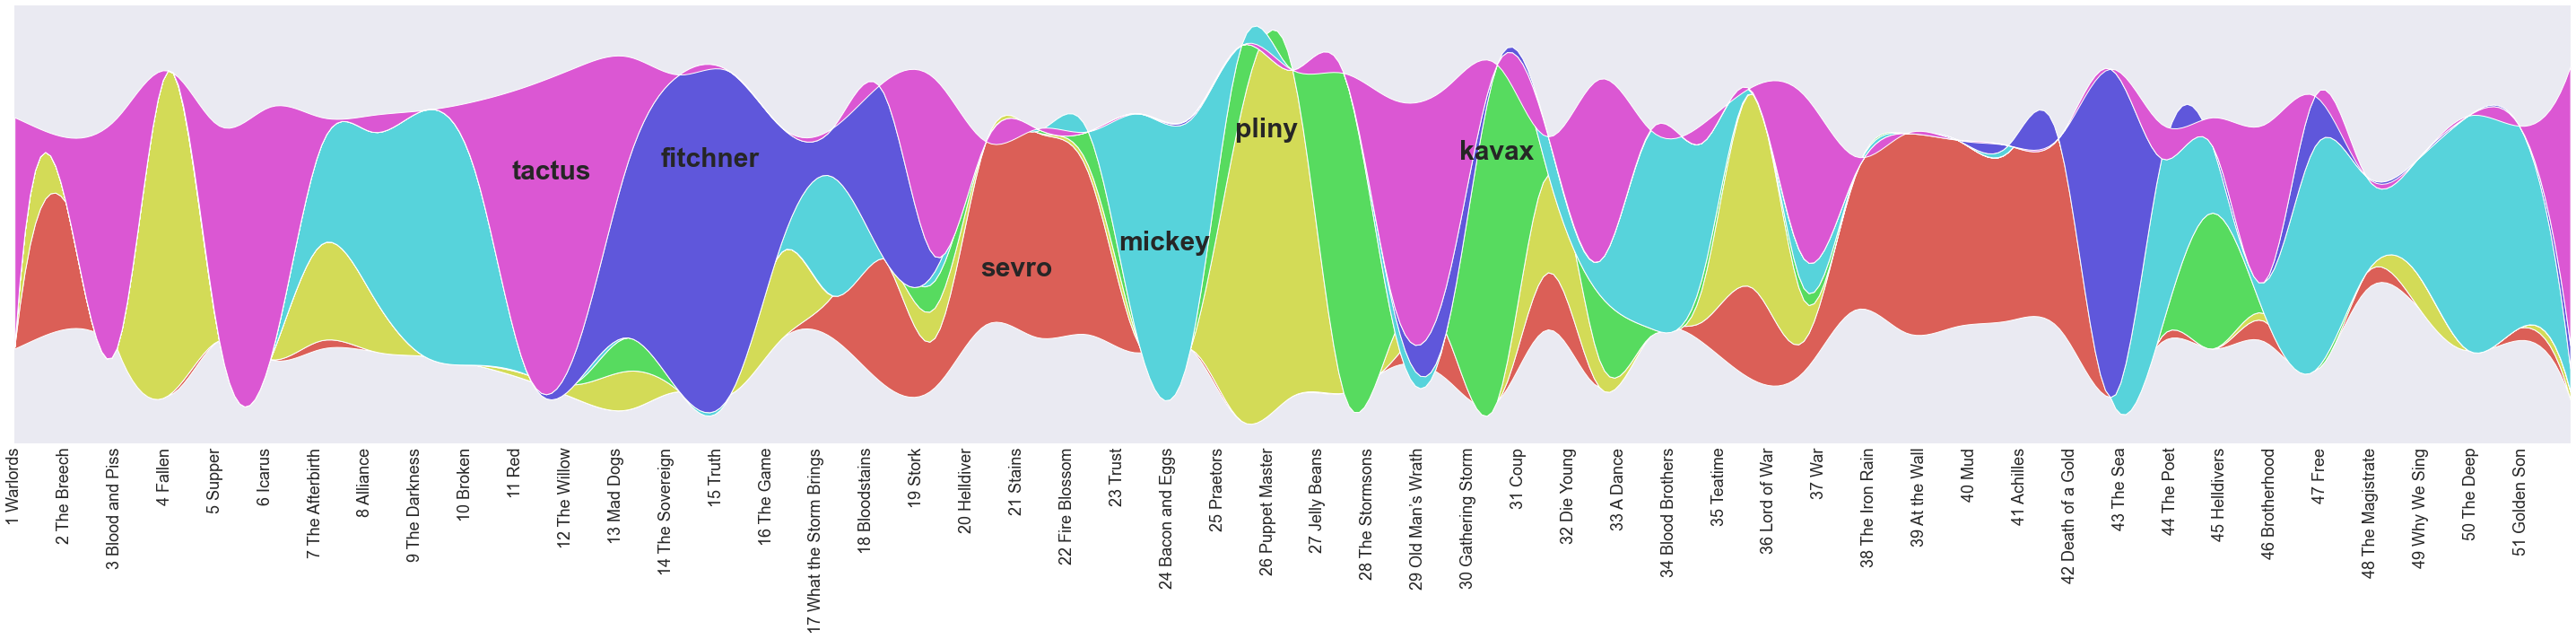

In [362]:
area_labels = comp_df_token.idxmax(axis=1)
# book 1
# area_labels[1] = "intro"

# book 2
# area_labels[4] = "spaceship\n(bridge)"

fig, ax = plt.subplots(figsize=(40, 10))

c_palette = "hls"  # hls or husl
my_cmap = list(sns.color_palette(c_palette, topic_progression.shape[1]).as_hex())

ax.stackplot(x_new_dim, topic_progression.T, baseline="sym", colors=my_cmap)
x_labels = data.index.get_level_values(0).str.replace('_', ' ').unique().tolist()
ax.set_xticks(np.arange(0, len(x_labels) , len(x_labels) / (len(x_labels) + 1))[:-1])
ax.set_xticklabels(x_labels)
ax.tick_params(axis="x", rotation=90, labelsize=18)

for idx, column in topic_progression.items():
    loc = column.argmax()
    ax.text(loc/10, topic_progression.iloc[loc, :].sum()*.8 - .35, area_labels[idx], fontsize=30, fontweight='extra bold', ha='center')

plt.yticks([])
ax.margins(x=0)

plt.style.use('seaborn-dark')
plt.tight_layout()
plt.savefig("book" + str(book_id) + "_2.png", dpi=500, format="png", transparent=True)
plt.show()

In [189]:
area_labels

0    mustang
1         eo
2    cassius
3     mickey
4       test
5     matteo
6     julian
7     dancer
dtype: object